# 05 - Trend Classification

Classify segments into meaningful categories for analysis.

## What You'll Learn
- Classify by trend direction (up/down/horizontal)
- Classify by volatility (clean vs noisy trends)
- Combined classification matrix
- Practical applications (finding consolidation, breakouts)

## Setup

In [1]:
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf

from trend_classifier import Segmenter
from trend_classifier.configuration import CONFIG_REL

warnings.filterwarnings("ignore")

# Download data
df = yf.download("AAPL", start="2018-09-15", end="2022-09-05", interval="1d", progress=False)

# Use CONFIG_REL for more segments to classify
seg = Segmenter(df=df, column="Close", config=CONFIG_REL)
seg.calculate_segments()

print(f"Classifying {len(seg.segments)} segments")

Classifying 25 segments


## Basic Classification by Direction

The simplest classification: up, down, or horizontal based on slope.

In [2]:
def classify_direction(segment, threshold=0.1):
    """Classify segment by slope direction."""
    if segment.slope > threshold:
        return "up"
    elif segment.slope < -threshold:
        return "down"
    else:
        return "horizontal"


# Classify all segments
classifications = [classify_direction(s) for s in seg.segments]

# Count
from collections import Counter
counts = Counter(classifications)
print("Direction Classification:")
for direction, count in counts.items():
    print(f"  {direction}: {count} segments ({100*count/len(seg.segments):.1f}%)")

Direction Classification:
  horizontal: 3 segments (12.0%)
  down: 10 segments (40.0%)
  up: 12 segments (48.0%)


### Visualize by Direction

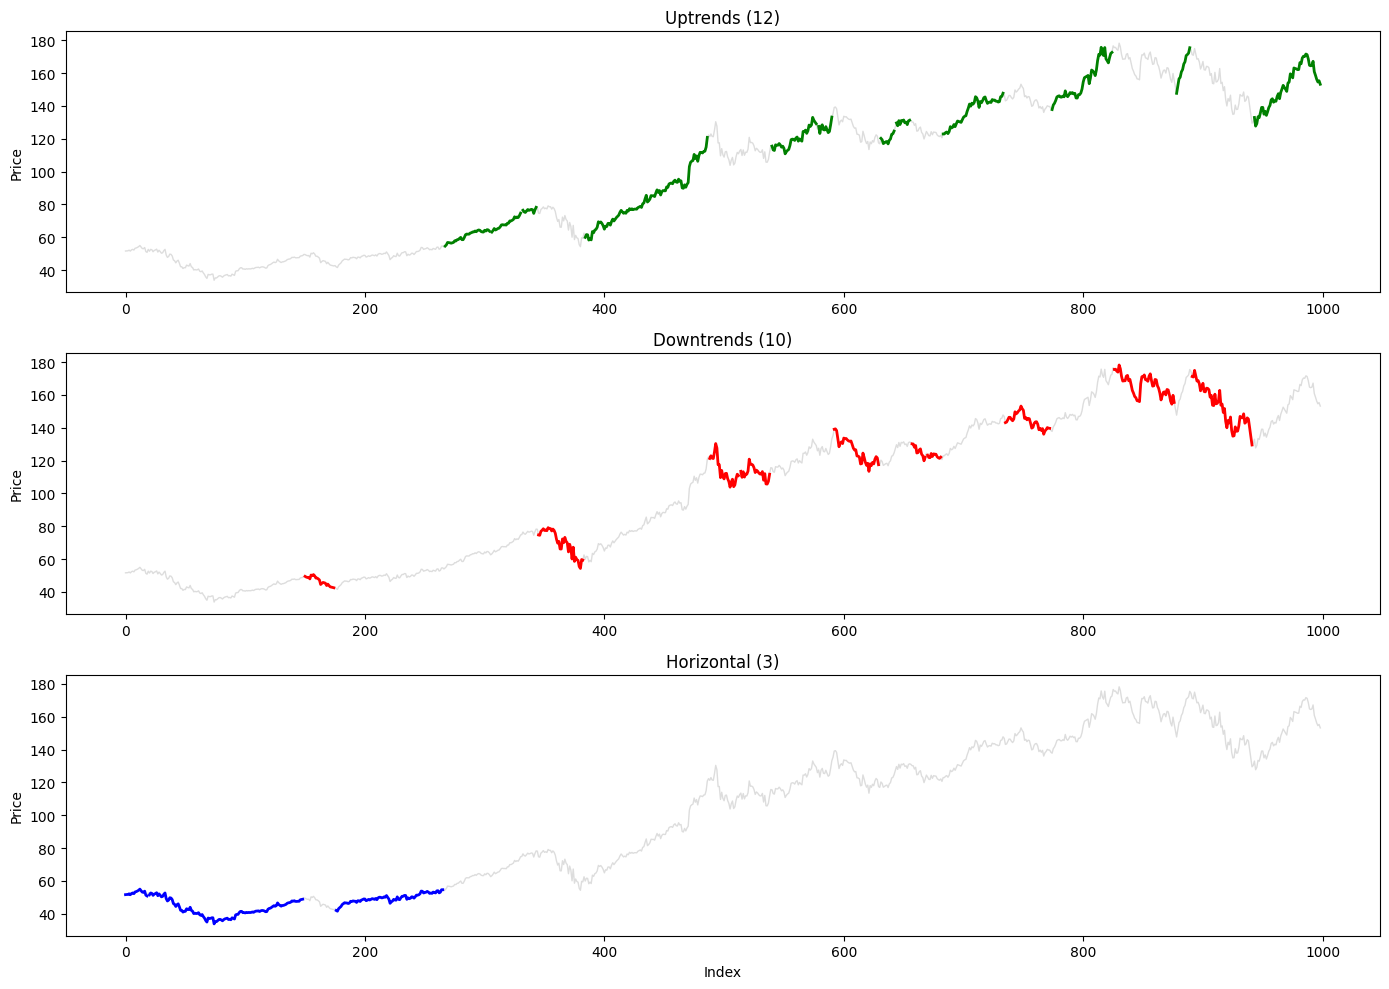

In [3]:
# Get indices for each category
up_idx = [i for i, c in enumerate(classifications) if c == "up"]
down_idx = [i for i, c in enumerate(classifications) if c == "down"]
horiz_idx = [i for i, c in enumerate(classifications) if c == "horizontal"]

fig, axes = plt.subplots(3, 1, figsize=(14, 10))

for ax, indices, title, color in [
    (axes[0], up_idx, f"Uptrends ({len(up_idx)})", "green"),
    (axes[1], down_idx, f"Downtrends ({len(down_idx)})", "red"),
    (axes[2], horiz_idx, f"Horizontal ({len(horiz_idx)})", "blue"),
]:
    ax.plot(seg.x, seg.y, color="#DDD", linewidth=1)
    for idx in indices:
        s = seg.segments[idx]
        ax.plot(seg.x[s.start:s.stop], seg.y[s.start:s.stop], color=color, linewidth=2)
    ax.set_title(title)
    ax.set_ylabel("Price")

axes[-1].set_xlabel("Index")
plt.tight_layout()
plt.show()

## Classification by Volatility

Use `std` (standard deviation after detrending) to classify trend quality:
- **Low volatility**: Clean, consistent trends
- **High volatility**: Noisy, choppy trends

In [4]:
# Analyze std distribution
stds = [s.std for s in seg.segments]
print(f"Volatility (std) range: {min(stds):.4f} to {max(stds):.4f}")
print(f"Median std: {pd.Series(stds).median():.4f}")

# Use median as threshold
std_threshold = pd.Series(stds).median()
print(f"\nUsing threshold: {std_threshold:.4f}")

Volatility (std) range: 0.5622 to 5.8883
Median std: 2.9155

Using threshold: 2.9155


In [5]:
def classify_volatility(segment, threshold):
    """Classify segment by volatility."""
    return "low" if segment.std < threshold else "high"


vol_classifications = [classify_volatility(s, std_threshold) for s in seg.segments]
vol_counts = Counter(vol_classifications)

print("Volatility Classification:")
for vol, count in vol_counts.items():
    print(f"  {vol} volatility: {count} segments")

Volatility Classification:
  low volatility: 12 segments
  high volatility: 13 segments


## Combined Classification Matrix

Combine direction and volatility for a 2x3 classification matrix:

|           | Low Volatility | High Volatility |
|-----------|----------------|-----------------|
| **Up**    | Clean uptrend  | Choppy uptrend  |
| **Down**  | Clean downtrend| Choppy downtrend|
| **Horizontal** | Consolidation | Ranging/Choppy |

In [6]:
def classify_segment(segment, slope_th=0.1, std_th=None):
    """Full classification of a segment."""
    direction = classify_direction(segment, slope_th)
    volatility = classify_volatility(segment, std_th)
    return f"{direction}_{volatility}"


# Classify all segments
full_classifications = [classify_segment(s, std_th=std_threshold) for s in seg.segments]
full_counts = Counter(full_classifications)

print("Combined Classification:")
for cat, count in sorted(full_counts.items()):
    print(f"  {cat}: {count} segments ({100*count/len(seg.segments):.1f}%)")

Combined Classification:
  down_high: 7 segments (28.0%)
  down_low: 3 segments (12.0%)
  horizontal_high: 1 segments (4.0%)
  horizontal_low: 2 segments (8.0%)
  up_high: 5 segments (20.0%)
  up_low: 7 segments (28.0%)


### Visualize Classification Matrix

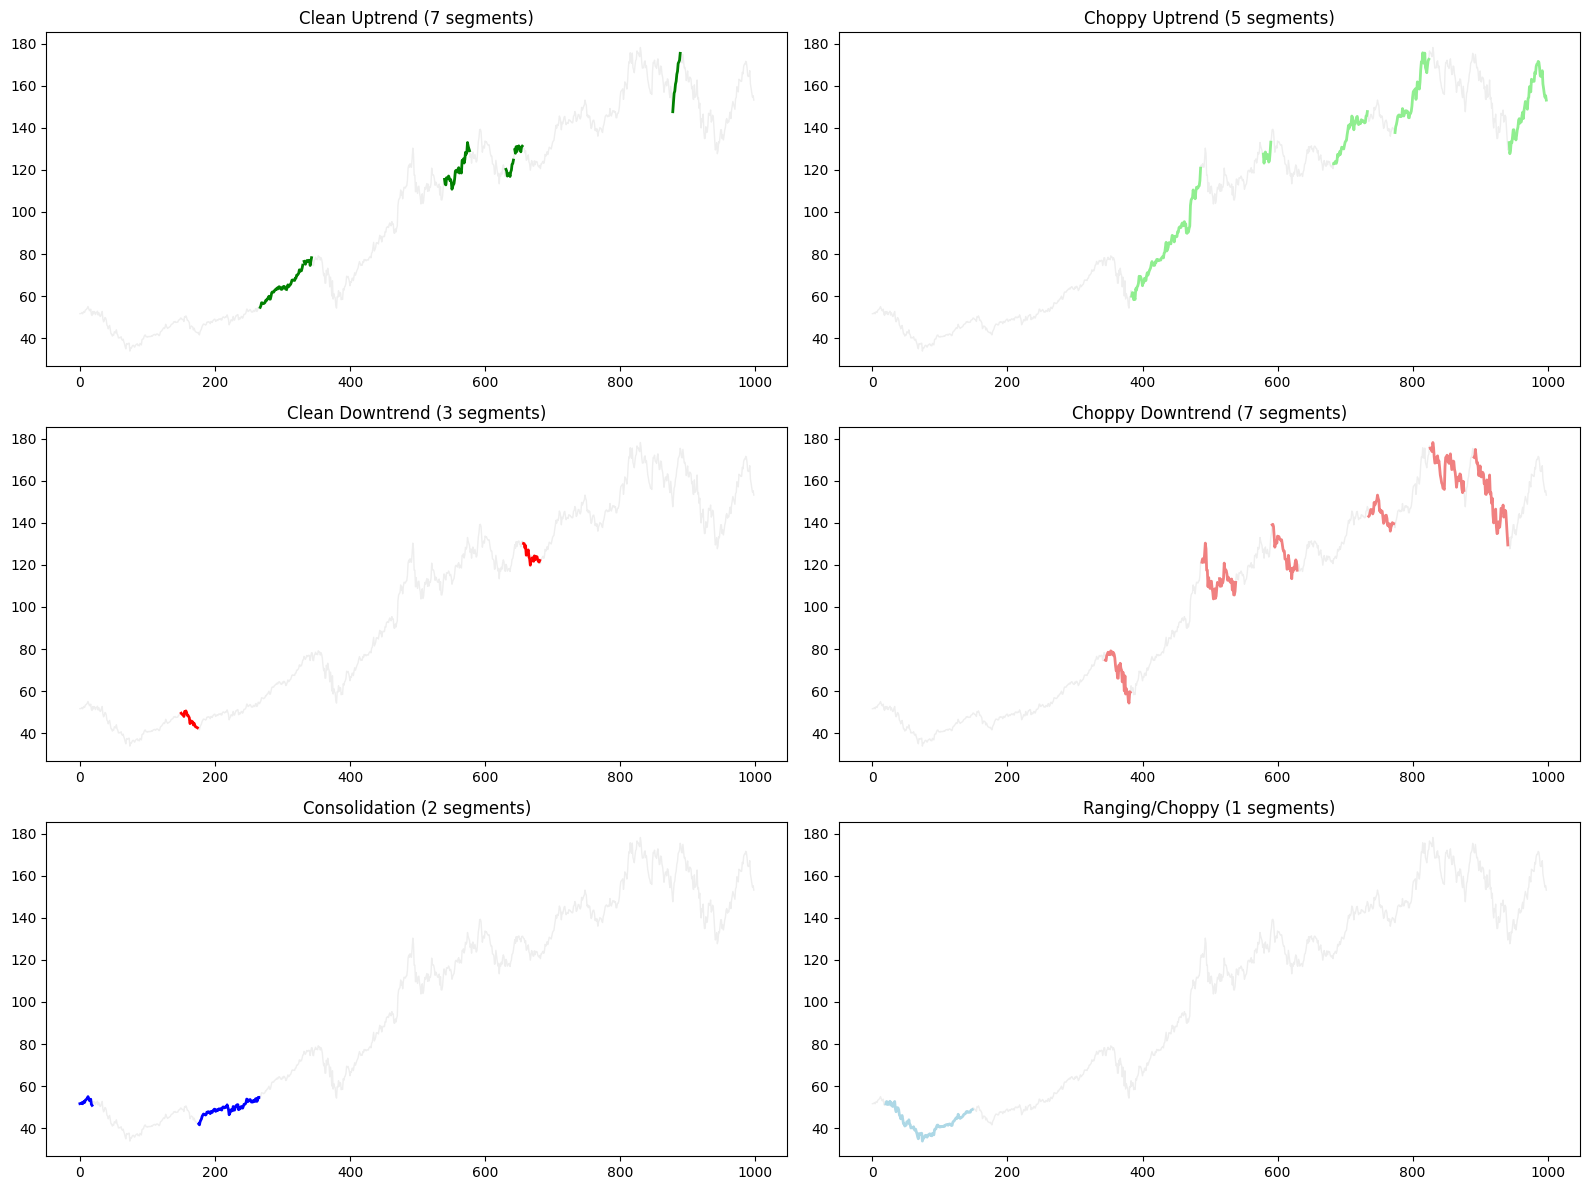

In [7]:
# Create 2x3 grid
categories = [
    ("up_low", "Clean Uptrend", "green"),
    ("up_high", "Choppy Uptrend", "lightgreen"),
    ("down_low", "Clean Downtrend", "red"),
    ("down_high", "Choppy Downtrend", "lightcoral"),
    ("horizontal_low", "Consolidation", "blue"),
    ("horizontal_high", "Ranging/Choppy", "lightblue"),
]

fig, axes = plt.subplots(3, 2, figsize=(16, 12))

for ax, (cat, title, color) in zip(axes.flat, categories):
    indices = [i for i, c in enumerate(full_classifications) if c == cat]
    
    ax.plot(seg.x, seg.y, color="#EEE", linewidth=1)
    for idx in indices:
        s = seg.segments[idx]
        ax.plot(seg.x[s.start:s.stop], seg.y[s.start:s.stop], color=color, linewidth=2)
    ax.set_title(f"{title} ({len(indices)} segments)")

plt.tight_layout()
plt.show()

## Practical Applications

### Finding Consolidation Periods

Horizontal + low volatility = potential breakout setup

Found 2 consolidation periods:
  Segment 0: index 0-19 (length=19)
  Segment 3: index 176-266 (length=90)


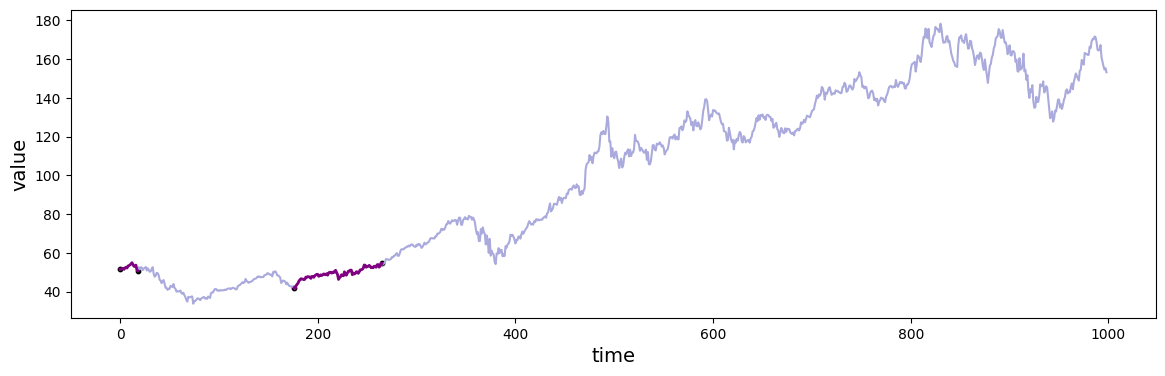

In [8]:
consolidation_idx = [i for i, c in enumerate(full_classifications) if c == "horizontal_low"]

if consolidation_idx:
    print(f"Found {len(consolidation_idx)} consolidation periods:")
    for idx in consolidation_idx:
        s = seg.segments[idx]
        print(f"  Segment {idx}: index {s.start}-{s.stop} (length={s.stop-s.start})")
    
    # Visualize
    seg.plot_segment(consolidation_idx, col="purple", fig_size=(14, 4))
else:
    print("No consolidation periods found with current thresholds")

### Finding Strong Trends

Up/Down + low volatility = strong directional moves

Strong uptrends: 7
Strong downtrends: 3


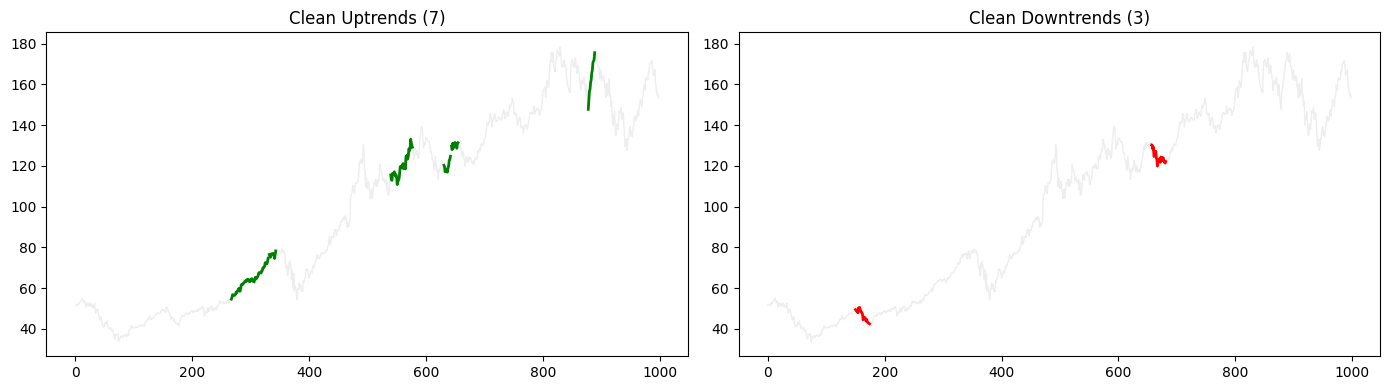

In [9]:
strong_up = [i for i, c in enumerate(full_classifications) if c == "up_low"]
strong_down = [i for i, c in enumerate(full_classifications) if c == "down_low"]

print(f"Strong uptrends: {len(strong_up)}")
print(f"Strong downtrends: {len(strong_down)}")

# Visualize strongest trends
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].plot(seg.x, seg.y, color="#EEE", linewidth=1)
for idx in strong_up:
    s = seg.segments[idx]
    axes[0].plot(seg.x[s.start:s.stop], seg.y[s.start:s.stop], color="green", linewidth=2)
axes[0].set_title(f"Clean Uptrends ({len(strong_up)})")

axes[1].plot(seg.x, seg.y, color="#EEE", linewidth=1)
for idx in strong_down:
    s = seg.segments[idx]
    axes[1].plot(seg.x[s.start:s.stop], seg.y[s.start:s.stop], color="red", linewidth=2)
axes[1].set_title(f"Clean Downtrends ({len(strong_down)})")

plt.tight_layout()
plt.show()

## Export Classification Results

In [10]:
# Create a DataFrame with all classifications
df_classified = seg.segments.to_dataframe()
df_classified["direction"] = [classify_direction(s) for s in seg.segments]
df_classified["volatility"] = vol_classifications
df_classified["category"] = full_classifications

# Show summary
df_classified[["start", "stop", "slope", "std", "direction", "volatility", "category"]].head(10)

,start,stop,slope,std,direction,volatility,category
0,0,19,0.051077,1.053919,horizontal,low,horizontal_low
1,20,149,-0.016503,4.840904,horizontal,high,horizontal_high
2,150,175,-0.329284,1.026187,down,low,down_low
3,176,266,0.094347,1.210777,horizontal,low,horizontal_low
4,267,305,0.256784,1.036989,up,low,up_low
5,306,331,0.433738,0.562207,up,low,up_low
6,332,344,0.143323,0.862855,up,low,up_low
7,345,383,-0.597368,3.312920,down,high,down_high
8,384,487,0.499898,3.671462,up,high,up_high
9,488,513,-0.749043,4.675545,down,high,down_high


In [11]:
# Summary statistics by category
print("Average slope by category:")
print(df_classified.groupby("category")["slope"].mean().round(4))

print("\nAverage volatility (std) by category:")
print(df_classified.groupby("category")["std"].mean().round(4))

Average slope by category:
category
down_high         -0.4802
down_low          -0.3866
horizontal_high   -0.0165
horizontal_low     0.0727
up_high            0.5633
up_low             0.6073
Name: slope, dtype: float64

Average volatility (std) by category:
category
down_high          3.8924
down_low           1.2280
horizontal_high    4.8409
horizontal_low     1.1323
up_high            3.8631
up_low             1.3916
Name: std, dtype: float64


## Next Steps

- **06_advanced_optimization.py** - Automatically find optimal parameters